# Config

In [ ]:
NUMBER_OF_REGIONS = 20
HIDDEN_LAYER_SIZE = (2, 5)
MAX_INPUT_LEN = 8000

In [ ]:
DATA_SOURCES = {'Kaggle': 0       # Kaggle, initial datasource on Kaggle, processing on Google servers
                , 'Gdrive': 1     # GDRIVE, reprocessed data sources, processing on Google servers
                , 'Local': 2      # localhost, for processing on local PC
}
DATA_SOURCE = DATA_SOURCES['Local']

LOAD_MODEL = 0

# Work with datasets

Download files from Kaggle

In [ ]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  ! pip install -q kaggle
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  #! kaggle datasets list
  ! kaggle competitions download -c novozymes-enzyme-stability-prediction
  ! mkdir novozymes_data
  ! unzip -o novozymes-enzyme-stability-prediction.zip -d novozymes_data
  ! mkdir train/
  ! mkdir test/
  ! \cp -r novozymes_data/train.csv train/train.csv
  ! \cp -r novozymes_data/train_updates_20220929.csv train/train_exclude.csv
  ! \cp -r novozymes_data/test.csv test/test.csv

In [ ]:
if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
from math import ceil
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  0


In [ ]:
if DATA_SOURCE == DATA_SOURCES['Local']:
  WORK_DIREKTORY = 'C:\\Novozymes\\'

  train_file = WORK_DIREKTORY + 'train.csv'
  train_excludes_file = WORK_DIREKTORY + 'train_updates_20220929.csv'

if DATA_SOURCE == DATA_SOURCES['Gdrive']:
  from google.colab import drive
  import os
  from distutils.dir_util import copy_tree

  WORK_DIREKTORY = '/content/gdrive/MyDrive/Colab Notebooks/Novozymes/'

  train_file = WORK_DIREKTORY + 'novozymes_dataset/train.csv'
  train_excludes_file = WORK_DIREKTORY + 'novozymes_dataset/train_updates_20220929.csv'

  drive.mount('/content/gdrive/', force_remount=True)

if DATA_SOURCE == DATA_SOURCES['Kaggle']:
  train_file = 'train/train.csv'
  train_excludes_file = 'train/train_exclude.csv'


In [ ]:
enzime_codes = []
labels = []
test_enzime_codes = []
test_labels = []

with open(train_excludes_file, 'r') as f:
  data_exclude = np.array([x.split(',') for x in f.readlines()])
data_exclude = np.array(data_exclude[data_exclude[:, 1] != ''][1:, 0], dtype=int)

with open(train_file, 'r') as f:
  #data = np.array([x.split(',') for x in f.readlines()[1:BATCH_SIZE]])
  while True:
    row = f.readline()
    if not row:
      break
    data_row = row.split(',')  
    if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id'):
      continue
    # print(data_row)
    try:
      if int(data_row[0])%51 == 0:
        test_labels.append(float(data_row[-1].replace('\n','')))
        test_enzime_codes.append([data_row[1], data_row[2]])
      else:
        labels.append(float(data_row[-1].replace('\n','')))
        enzime_codes.append([data_row[1], data_row[2]])
    except Exception:
      print(data_row)
      raise Exception

train_dataset = tf.data.Dataset.from_tensor_slices((np.array(enzime_codes), np.array(labels))).shuffle(len(enzime_codes))
control_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_enzime_codes), np.array(test_labels))).shuffle(len(test_enzime_codes))

C:\Users\hp\AppData\Local\Temp\ipykernel_11232\3418302902.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (data_row[0] in data_exclude) or (data_row[0] == 'seq_id'):


In [ ]:
next(iter(control_dataset))

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'MQKEQLSALMDGETLDSELLNELAHNPEMQKTWESYHLIRDSMRGDTPEVLHFDISSRVMAAIEEEPVRQPATLIPEAQPAPHQWQKMPFWQKVRPWAAQLTQMGVAACVSLAVIVGVQHYNGQSETSQQPETPVFNTLPMMGKASPVSLGVPSEATANNGQQQQVQEQRRRINAMLQDYELQRRLHSEQLQFEQAQTQQAAVQVPGIQTLGTQS',
        b'7.0'], dtype=object)>,
 <tf.Tensor: shape=(), dtype=float64, numpy=56.3>)

# Research

Read and clean data

In [ ]:
def res_normalized(y: np.array) -> np.array:
  return y / 150

def res_sigmoid(y: np.array) -> np.array:
  return 1 / (1 + np.exp(- (y - 50)/7.5))

def res_tanh(y: np.array) -> np.array:
  return np.tanh((y - 50)/10)

def res_arcsinh_norm(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)/10 + 0.5

def res_arcsinh(y: np.array) -> np.array:
  return np.arcsinh((y-50)/2)

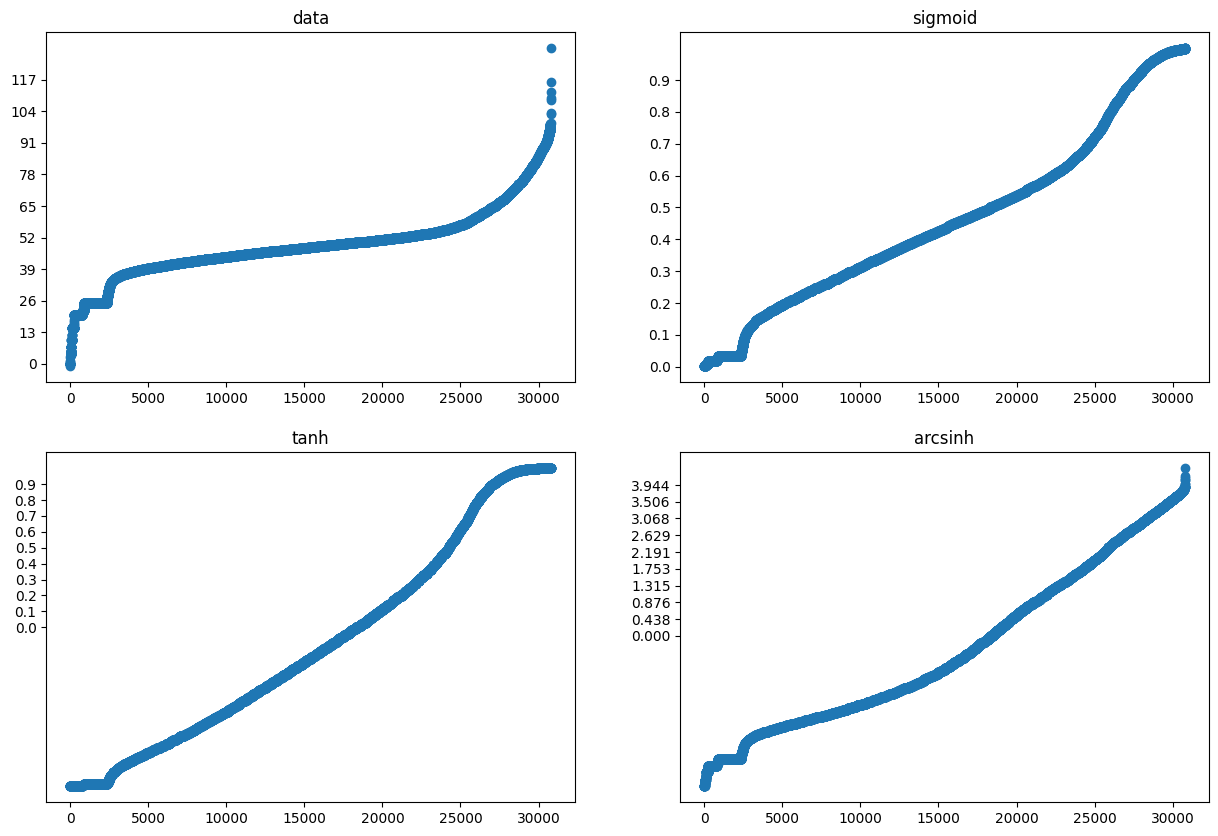

In [ ]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

y_data = np.array(labels, dtype=float)

plt.subplot(2,2,1)
plt.scatter( np.arange(0,len(y_data)), np.sort(y_data))
ax[0, 0].set(yticks=np.arange(0, 10)*np.max(y_data)/10)
plt.title('data')

plt.subplot(2,2,2)
y_sigmoid = res_sigmoid(y_data) 
plt.scatter( np.arange(0,len(y_sigmoid)), np.sort(y_sigmoid))
ax[1, 0].set(yticks=np.arange(0, 10)*np.max(y_sigmoid)/10)
plt.title('sigmoid')

plt.subplot(2,2,3)
y_tanh = res_tanh(y_data) 
plt.scatter( np.arange(0,len(y_tanh)), np.sort(y_tanh))
ax[0, 1].set(yticks=np.arange(0, 10)*np.max(y_tanh)/10)
plt.title('tanh')

plt.subplot(2,2,4)
y_arcsinh = res_arcsinh(y_data) 
plt.scatter( np.arange(0,len(y_arcsinh)), np.sort(y_arcsinh))
ax[1, 1].set(yticks=np.arange(0, 10)*np.max(y_arcsinh)/10)
plt.title('arcsinh')

plt.show()

We will try to use as a labels and as result for our model **res_sigmoid(tm)** or **res_tanh(tm)** or **res_arcsinh(tm)**, cause it allows us to seek more steady solution, without some extremly low and hight cases. Shall check them all, probably.

# Convolution

In [ ]:
MAX_LENGTH = 0

# Create dictionary for protein_sequence
dictionary = {}
for d in enzime_codes:
  MAX_LENGTH = max(MAX_LENGTH, len(d[0]))
  for l in list(bytes(d[0], "utf8")):
    if l not in dictionary:
      dictionary[l] = 0
    dictionary[l] += 1

print(len(dictionary))
vocab = np.array(sorted(dictionary.items()))[:, 0]
#dictionary = tuple(enumerate(tf.constant(np.array(sorted(dictionary.items()))[:, 0])))
vocab_dict = dict(np.array(list(enumerate(vocab)))[:, [1, 0]])
print(vocab)
print(MAX_LENGTH)

AMINO_ACIDS_COUNT = len(dictionary)
TEMPLATE_COUNT = pow(AMINO_ACIDS_COUNT, 2)

20
[65 67 68 69 70 71 72 73 75 76 77 78 80 81 82 83 84 86 87 89]
32767


# Time for neuro net

It is like this logic, but faster:

```
for i1 in np.arange(AMINO_ACIDS_COUNT):
  for i2 in np.arange(AMINO_ACIDS_COUNT):
    for i3 in np.arange(AMINO_ACIDS_COUNT):
      for i4 in np.arange(AMINO_ACIDS_COUNT):
        conv_compact[i1, i2, i3, i4, :] = np.dot(conv[i1, i2, i3, i4, :], aggregator[i1, i2, i3, :, :])
```



In [ ]:
# Prepare dataset with preprocessing

def NovozymesPreprocess(inputs, label, dictionary, conf: tf.Tensor) -> np.array:

  #print(inputs)
  AMINO_ACIDS_COUNT = conf[0]
  NUMBER_OF_REGIONS = conf[1]
  inp = inputs[0].numpy()
  if len(inp) > MAX_INPUT_LEN:
    enzime_code = inp[:MAX_INPUT_LEN]
  else: 
    enzime_code = inp
  PH_str = inputs[1].numpy()
  PH_level = float(PH_str) if PH_str != b'' else 0
  enzime_code_len = len(enzime_code)

  #print(enzime_code)

  enzime_to_int = np.zeros(shape=(MAX_INPUT_LEN, 2), dtype=np.float32)

  for i, amin in enumerate(list(enzime_code)):
    enzime_to_int[i, 0] = np.argwhere(vocab==amin)[0][0]
  enzime_to_int[:, 1] = enzime_to_int[:, 1] + PH_level

  #print(enzime_to_int)

  return [enzime_to_int], [res_sigmoid(label)]


data_tf = train_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              #, num_parallel_calls = tf.data.AUTOTUNE
                            )
test = next(iter(data_tf))
print(test)
print(data_tf.element_spec)


(<tf.Tensor: shape=(1, 8000, 2), dtype=float32, numpy=
array([[[10.,  7.],
        [15.,  7.],
        [17.,  7.],
        ...,
        [ 0.,  7.],
        [ 0.,  7.],
        [ 0.,  7.]]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.13238887])>)
(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))


In [ ]:
"""
from keras.utils.vis_utils import plot_model

x = tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS), dtype=tf.float32)
inside = tf.keras.layers.LocallyConnected1D(1, 1, implementation=3)(x)
inside = tf.keras.layers.Flatten()(inside)
y = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inside)

model = tf.keras.Model(x, y)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)
"""

'\nfrom keras.utils.vis_utils import plot_model\n\nx = tf.keras.Input(shape=(TEMPLATE_COUNT, NUMBER_OF_REGIONS), dtype=tf.float32)\ninside = tf.keras.layers.LocallyConnected1D(1, 1, implementation=3)(x)\ninside = tf.keras.layers.Flatten()(inside)\ny = tf.keras.layers.Dense(1, activation=tf.nn.relu)(inside)\n\nmodel = tf.keras.Model(x, y)\n\nprint(model.summary())\nplot_model(model, show_shapes=True, show_layer_names=True)\n'

In [ ]:
from keras.utils.vis_utils import plot_model

if not LOAD_MODEL:  

  MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save\\model 20221123 CNN\\'

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(MAX_INPUT_LEN, 2), dtype=tf.float32))
  model.add(tf.keras.layers.Conv1D(50, 2, activation=tf.keras.activations.swish))
  model.add(tf.keras.layers.MaxPool1D(4))
  model.add(tf.keras.layers.Conv1D(20, 5, activation=tf.keras.activations.swish))
  model.add(tf.keras.layers.MaxPool1D(4))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], activation=tf.keras.activations.swish))
  model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.0001,
      decay_steps=30000*100,
      decay_rate=0.1)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
                , loss=tf.keras.losses.MeanSquaredError()
                , metrics=[tf.keras.metrics.MeanAbsoluteError()])
else:
  MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/'
  model = tf.keras.models.load_model('{}my_model.h5'.format(MODEL_DIREKTORY))  

print(model.summary())
#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7999, 50)          250       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1999, 50)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1995, 20)          5020      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 498, 20)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9960)              0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [ ]:
if 0:
  #MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save\\model 20221123 CNN\\'
  model = tf.keras.models.load_model('{}auto_save_model_168.h5'.format(MODEL_DIREKTORY))  

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=30000*90,
      decay_rate=0.1)
model.optimizer.learning_rate=lr_schedule

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger

#MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221123 CNN/'
checkpoint = ModelCheckpoint(MODEL_DIREKTORY + 'auto_save_model_{epoch:02d}.h5', monitor='loss',
    save_best_only=False, mode='auto', save_freq='epoch')
logger = CSVLogger(MODEL_DIREKTORY + 'learning_logs.log', append=True)

In [ ]:
epoch_cnt = 300
fit_history = model.fit(iter(data_tf.repeat(epoch_cnt))
                , batch_size=1
                , epochs=epoch_cnt
                , steps_per_epoch=len(data_tf)
                #, initial_epoch = 168
                , validation_data = control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
                          inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                          , Tout=(tf.float32, tf.float64))
                          )
                #, callbacks=[checkpoint, logger]
                )

Epoch 1/300
30774/30774 [==============================] - 543s 18ms/step - loss: 0.0692 - mean_absolute_error: 0.2150 - val_loss: 0.0647 - val_mean_absolute_error: 0.2091
Epoch 2/300
30774/30774 [==============================] - 546s 18ms/step - loss: 0.0641 - mean_absolute_error: 0.2063 - val_loss: 0.0818 - val_mean_absolute_error: 0.2243
Epoch 3/300
30774/30774 [==============================] - 547s 18ms/step - loss: 0.0622 - mean_absolute_error: 0.2020 - val_loss: 0.0631 - val_mean_absolute_error: 0.2057
Epoch 4/300
30774/30774 [==============================] - 512s 17ms/step - loss: 0.0605 - mean_absolute_error: 0.1984 - val_loss: 0.0614 - val_mean_absolute_error: 0.2016
Epoch 5/300
30774/30774 [==============================] - 523s 17ms/step - loss: 0.0592 - mean_absolute_error: 0.1957 - val_loss: 0.0602 - val_mean_absolute_error: 0.2002
Epoch 6/300
30774/30774 [==============================] - 515s 17ms/step - loss: 0.0582 - mean_absolute_error: 0.1935 - val_loss: 0.0585 - 

KeyboardInterrupt: ignored

In [ ]:
for i in range(70):
  #MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/model 20221123 CNN/'
  model = tf.keras.models.load_model('{}auto_save_model_{:02d}.h5'.format(MODEL_DIREKTORY, i+1))  
  print(np.mean(model.layers[0].get_weights()[0])
        , np.mean(model.layers[2].get_weights()[0])
        , np.mean(model.layers[6].get_weights()[0])
        , np.mean(model.layers[7].get_weights()[0]))

In [ ]:
# try to stupy worst cases
updates = 0
while 0:
  ind = np.random.choice(np.array(range(len(enzime_codes))))
  #print((np.array(enzime_codes[ind]), np.array(labels[ind])))
  one_elem_dataset = tf.data.Dataset.from_tensors((np.array(enzime_codes[ind]), np.array(labels[ind])))
  test = one_elem_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess,
            inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])], Tout=(tf.float32, tf.float64)))
  if model.evaluate(test)[1] > 50:
    model.fit(iter(test.repeat(10)), epochs = 10, steps_per_epoch=1)
    updates += 1
    print('updates = {}'.format(updates))
    if updates == 3000:
      break

In [ ]:
if DATA_SOURCE == DATA_SOURCES['Local']:
  import os 
  MODEL_DIREKTORY = WORK_DIREKTORY + 'model_save/'
  #os.system('mkdir -p {}'.format(MODEL_DIREKTORY))
  model.save('{}my_model.h5'.format(MODEL_DIREKTORY))

In [ ]:
model.evaluate(control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE))

In [ ]:
# check 5 examples

for nx in control_dataset.map(lambda x, y: tf.py_function(func=NovozymesPreprocess
                                              , inp=[x, y, vocab, tf.constant([AMINO_ACIDS_COUNT, NUMBER_OF_REGIONS])]
                                              , Tout=(tf.float32, tf.float64))
                                              , num_parallel_calls = tf.data.AUTOTUNE).take(5):
  print((model.predict(nx[0]), nx[1]))
  print(model.evaluate(nx[0], nx[1]))

1/1 [==============================] - 0s 24ms/step
(array([[0.5087586]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.52664141])>)
1/1 [==============================] - 0s 26ms/step - loss: 3.1980e-04 - mean_absolute_error: 0.0179
[0.0003197953919880092, 0.017882823944091797]
1/1 [==============================] - 0s 24ms/step
(array([[0.50684065]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.42392858])>)
1/1 [==============================] - 0s 23ms/step - loss: 0.0069 - mean_absolute_error: 0.0829
[0.006874409504234791, 0.08291205763816833]
1/1 [==============================] - 0s 22ms/step
(array([[0.4841942]], dtype=float32), <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.61774787])>)
1/1 [==============================] - 0s 25ms/step - loss: 0.0178 - mean_absolute_error: 0.1336
[0.017836594954133034, 0.13355371356010437]
1/1 [==============================] - 0s 24ms/step
(array([[0.3640996]], dtype=float32), <tf.Tenso

In [ ]:
print(fit_history.history.keys())

fig, ax = plt.subplots()

y_data_1 = np.array(fit_history.history['mean_absolute_percentage_error'], dtype=float)
y_data_2 = np.array(fit_history.history['val_mean_absolute_percentage_error'], dtype=float)

plt.scatter( np.arange(0,len(y_data_1)), y_data_1, label='Train')
plt.scatter( np.arange(0,len(y_data_2)), y_data_2, label='Validation')
plt.title('History')
plt.legend()
plt.show()

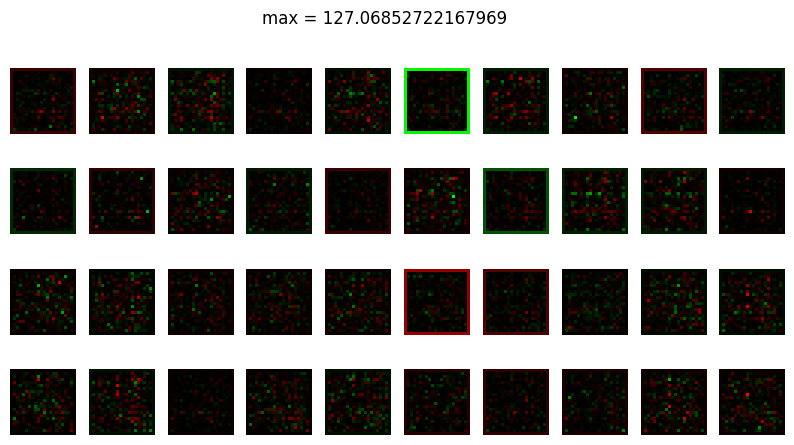

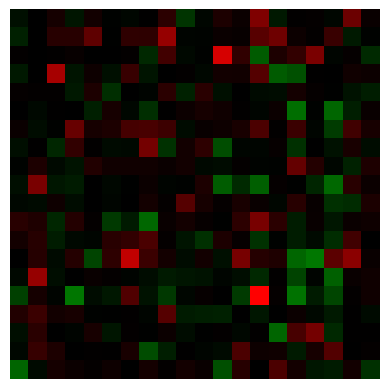

In [ ]:

coefs_layer2 = model.layers[2].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1])
coefs_layer0 = model.layers[0].get_weights()[0].reshape(  AMINO_ACIDS_COUNT
                                                        , AMINO_ACIDS_COUNT
                                                        , NUMBER_OF_REGIONS+1)

templates_coeffs = model.layers[3].get_weights()[0]

vyhodnoceni = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
colors = np.zeros((HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1], AMINO_ACIDS_COUNT+2, AMINO_ACIDS_COUNT+2, 3), dtype=float)

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
      vyhodnoceni[r, i, j] = np.sum(coefs_layer0[i, j, :]) * np.sum(coefs_layer2[i, j, r])

#print(vyhodnoceni)
max_coeff = np.max(np.abs(vyhodnoceni))
vyhodnoceni = vyhodnoceni / max_coeff

for r in range(HIDDEN_LAYER_SIZE[0]*HIDDEN_LAYER_SIZE[1]):
  for i in range(AMINO_ACIDS_COUNT):
    for j in range(AMINO_ACIDS_COUNT):
      col = vyhodnoceni[r, i, j]
      colors[r, i+1, j+1] = [-col if col < 0 else 0, col if col > 0 else 0, 0]
  template_solor = [-templates_coeffs[r][0] if templates_coeffs[r][0] < 0 else 0, templates_coeffs[r][0] if templates_coeffs[r][0] > 0 else 0, 0]
  colors[r, 0, :] = template_solor
  colors[r, -1, :] = template_solor
  colors[r, :, -1] = template_solor
  colors[r, :, 0] = template_solor

aggregation = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT))
agg_colors = np.zeros((AMINO_ACIDS_COUNT, AMINO_ACIDS_COUNT, 3), dtype=float)
for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    aggregation[i, j] = np.sum(vyhodnoceni[:, i, j]*templates_coeffs[:, 0]) 
aggregation = aggregation / np.max(np.abs(aggregation))

for i in range(AMINO_ACIDS_COUNT):
  for j in range(AMINO_ACIDS_COUNT):
    col = aggregation[i, j]
    agg_colors[i, j, :] = [-col if col < 0 else 0, col if col > 0 else 0, 0]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], figsize=(10, 5))
fig.suptitle('max = {}'.format(max_coeff))

for i in range(HIDDEN_LAYER_SIZE[0]):
  for j in range(HIDDEN_LAYER_SIZE[1]):
    plt.subplot(HIDDEN_LAYER_SIZE[0], HIDDEN_LAYER_SIZE[1], HIDDEN_LAYER_SIZE[1]*i + j + 1)
    plt.imshow(colors[HIDDEN_LAYER_SIZE[1]*i + j, :, :, :], interpolation='none', aspect='equal')
    plt.axis('off')

plt.show()

plt.imshow(agg_colors, interpolation='none', aspect='equal')
plt.axis('off')
plt.show()